In [1]:
"""
@file four_class_classification.ipynb
@author Ryan Missel

This notebook handles testing a simple classification case where 4 Gaussian distribution clusters
are plotted near each other and the network is tasked with classifying them. The idea is to check
the decision boundaries outside of the training data for their classification and checking the
organization of the MetaPrior meta-space.

This will be extended to adding local codes for each data point and check how the drawn latent codes
are organized per class.
"""
import math
import time
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as func
from tqdm.notebook import tqdm

from IPython.display import clear_output
import matplotlib.pyplot as plt

from scipy.stats import entropy
from metaprior.metautils import get_act, plot_metaspace_mean, plot_metaspace_var, plot_weight_correlations
from torch.distributions import Normal, kl_divergence as kl

In [2]:
class MetaPrior(nn.Module):
    def __init__(self, layer_sizes=[1, 100, 1], mean=False, local=False, activation='linear', hyperprior_dim=32, code_dim=2):
        super(MetaPrior, self).__init__()
        self.input_dim = layer_sizes[0]
        self.layer_sizes = layer_sizes
        self.code_dim = code_dim

        self.local = local
        self.mean = mean

        self.acts = [get_act('leaky_relu') if i < len(layer_sizes) - 2 else get_act(activation)
                         for i in range(len(layer_sizes) - 1)]

        self.embedder = nn.Sequential(
            nn.Linear(self.input_dim, 20),
            nn.LeakyReLU(),
            nn.Linear(20, code_dim)
        )

        # Define the initial weight code distribution parameters
        self.code_mu = nn.ParameterList([
            torch.nn.Parameter(
                torch.zeros([lsize, code_dim]) + 0.1 * torch.randn([lsize, code_dim], requires_grad=True),
                requires_grad=True)
            for lsize in self.layer_sizes
        ])

        self.code_var = nn.ParameterList([
            torch.nn.Parameter(torch.ones([lsize, code_dim]), # + 0.1 * torch.randn([lsize, code_dim], requires_grad=True),
                               requires_grad=True)
            for lsize in self.layer_sizes
        ])

        self.codes = [
            torch.randn([lsize, code_dim]) for lsize in self.layer_sizes
        ]


        # Define the hyperprior network that generates the distribution parameters of the Weights
        self.hyperprior = nn.Sequential(
            nn.Linear(code_dim * 2, 64),
            nn.LeakyReLU(),
            nn.Linear(64, hyperprior_dim)
        )

        self.mean_net = nn.Linear(hyperprior_dim, 1)
        self.var_net = nn.Linear(hyperprior_dim, 1)

    def generate_weight_codes(self):
        """
        Handles building the weight codes and draw samples from i
        :return:
        """
        # Sample the codes array
        self.codes = [
            self.code_mu[i] + torch.randn_like(self.code_mu[i]) * self.code_var[i]
            for i in range(len(self.layer_sizes))
        ]

        self.weight_codes = []
        self.bias_codes = []

        # Loop between the layers and generate their weight codes by concatenating each units' latent var.
        # Units in the smaller layer need to be duplicated to the size of the next layer in order to perform
        # easy concatenation between their latent variables
        for idx in range(len(self.layer_sizes) - 1):
            temp = self.codes[idx].unsqueeze(1).repeat(1, self.layer_sizes[idx + 1], 1).view([-1, self.code_dim])
            temp2 = self.codes[idx + 1].unsqueeze(0).repeat(self.layer_sizes[idx], 1, 1).view([-1, self.code_dim])
            concated = torch.cat((temp2, temp), dim=1)

            self.weight_codes.append(concated)

            # Generate bias codes (concatenation is just with a zeros vector)
            self.bias_codes.append(torch.cat((self.codes[idx + 1], torch.zeros_like(self.codes[idx + 1])), dim=1))

    def kl_term(self):
        """
        KL term related to the distribution parameters of the meta-variables, with prior N(0, 1)
        :return: Sum of the KL values over each latent variable
        """
        mus = torch.cat([cmu.view([-1]) for cmu in self.code_mu])
        var = torch.cat([cvar.view([-1]) for cvar in self.code_var])

        q = Normal(mus, var)
        N = Normal(torch.zeros(len(mus), device=mus.device), torch.ones(len(mus), device=mus.device))
        klz = kl(q, N).sum()
        return klz

    def forward(self, x, perturb=False):
        """
        Handles iterating through each layer, generating the distribution parameters and sampling
        the weights and biases for that layer
        :param x: input x
        :param perturb: whether to perturb one meta-var
        """
        # Generate weight codes given current latent codes
        self.generate_weight_codes()
        local_code = self.embedder(x)

        # Perturb one meta-var to test function draws
        if perturb:
            indice = np.random.randint(0, self.weight_codes[0].shape[0], 1)
            self.weight_codes[0][indice] += torch.hstack((torch.zeros([2]), 2 * torch.randn([2])))

        # Iterate over layers to get output
        for lidx in range(len(self.layer_sizes) - 1):
            # Get latent codes of hyperprior
            if self.local:
                latent_w = self.hyperprior(torch.cat((self.weight_codes[lidx], local_code), dim=1))
                latent_b = self.hyperprior(torch.cat((self.bias_codes[lidx], local_code), dim=1))
            else:
                latent_w = self.hyperprior(self.weight_codes[lidx])
                latent_b = self.hyperprior(self.bias_codes[lidx])

            # Sample weights
            w_mu, w_var = self.mean_net(latent_w), self.var_net(latent_w)
            w = (w_mu + torch.randn_like(w_mu) * w_var).view([self.layer_sizes[lidx], self.layer_sizes[lidx + 1]])

            # Sample biases
            b_mu, b_var = self.mean_net(latent_b), self.var_net(latent_b)
            b = (b_mu + torch.randn_like(b_mu) * b_var).squeeze()

            # Perform the linear layer and activate
            x = func.linear(x, w.T, b)
            x = self.acts[lidx](x)
            
        return x

    def bce_predict(self, x):
        """ Simply turns the softmax outputs into full class predictions """
        # Apply softmax to output.
        pred = self.forward(x)

        ans = []
        # Pick the class with maximum weight
        for t in pred:
            if t < 0.5:
                ans.append(0)
            else:
                ans.append(1)
        return ans

    def ce_predict(self, x):
        """ Get class predictions from prediction vector """
        pred = self.forward(x).detach().cpu().numpy()
        argmax = np.argmax(pred, axis=1)
        return argmax

    def weight_correlations(self, x, indice, layer, shift):
        """ Get the weight vectors of two random nodes to another """
        # Clamp the weight code to its distribution mean
        # self.codes = [self.code_mu[i] for i in range(len(self.layer_sizes))]
        self.codes = [
            self.code_mu[i] + torch.randn_like(self.code_mu[i]) * self.code_var[i]
            for i in range(len(self.layer_sizes))
        ]

        self.codes[layer + 1][indice] = self.code_mu[layer + 1][indice] + torch.Tensor(shift)

        # Generate weight codes
        self.weight_codes = []
        self.bias_codes = []

        # Loop between the layers and generate their weight codes by concatenating each units' latent var.
        # Units in the smaller layer need to be duplicated to the size of the next layer in order to perform
        # easy concatenation between their latent variables
        for idx in range(len(self.layer_sizes) - 1):
            temp = self.codes[idx].unsqueeze(1).repeat(1, self.layer_sizes[idx + 1], 1).view([-1, self.code_dim])
            temp2 = self.codes[idx + 1].unsqueeze(0).repeat(self.layer_sizes[idx], 1, 1).view([-1, self.code_dim])
            concated = torch.cat((temp, temp2), dim=1)

            self.weight_codes.append(concated)

            # Generate bias codes (concatenation is just with a zeros vector)
            self.bias_codes.append(torch.cat((self.codes[idx + 1], torch.zeros_like(self.codes[idx + 1])), dim=1))

        # Iterate over layers to get output
        w_out = None
        for lidx in range(len(self.layer_sizes) - 1):
            # Get latent codes of hyperprior
            latent_w = self.hyperprior(self.weight_codes[lidx])
            latent_b = self.hyperprior(self.bias_codes[lidx])

            # Sample weights
            w_mu, w_var = self.mean_net(latent_w), self.var_net(latent_w)
            w = (w_mu + torch.randn_like(w_mu) * w_var.exp()).view([self.layer_sizes[lidx], self.layer_sizes[lidx + 1]])

            # Get the sampled weight for the specific layer
            if lidx == layer:
                w_out = w

            # Sample biases
            b_mu, b_var = self.mean_net(latent_b), self.var_net(latent_b)
            b = (b_mu + torch.randn_like(b_mu) * b_var.exp()).squeeze()

            # Perform the linear layer and activate
            x = func.linear(x, w.T, b)
            print(self.acts[lidx])
            x = self.acts[lidx](x)

        # Return only the node weights that are cared about
        return x, w_out[:, indice]

In [3]:
class OldNet(nn.Module):
    def __init__(self, layer_sizes=[1, 100, 1], mean=False, local=False, activation='linear', hyperprior_dim=32, code_dim=2):
        super(OldNet, self).__init__()
        self.input_dim = layer_sizes[0]
        self.layer_sizes = layer_sizes
        self.code_dim = code_dim

        self.priorlog = math.log(0.1)
        
        self.local = local
        self.mean = mean

        self.acts = [get_act('leaky_relu') if i < len(layer_sizes) - 2 else get_act(activation)
                         for i in range(len(layer_sizes) - 1)]
        print("Activations: ", self.acts)
        
        """ Codes """
        self.code_mu = nn.ParameterList([])
        self.code_var = nn.ParameterList([])
        for lidx in range(len(layer_sizes)):
            code = torch.nn.Parameter(
                torch.zeros([layer_sizes[lidx], self.code_dim]),
                requires_grad=True
            )
            self.code_mu.append(code)
        
        for lidx in range(len(layer_sizes)):
            code = torch.nn.Parameter(
                torch.ones([layer_sizes[lidx], self.code_dim]),
                requires_grad=True
            )
            self.code_var.append(code)
        
        self.codes = [1, 2, 3, 4]
        
        self.hyperprior = nn.Sequential(
            nn.Linear(self.code_dim * 2, 36),
            nn.ReLU(),
            nn.Linear(36, 36),
            nn.ReLU(),
            nn.Linear(36, 1),
        )
        
        self.reset_parameters()
    
    def reset_parameters(self):
        for lidx in range(len(self.layer_sizes)):
            # Initialization method of Adv-BNN
            stdv = 1. / math.sqrt(self.code_mu[lidx].size(1))
            self.code_mu[lidx].data.uniform_(-stdv, stdv)
            self.code_var[lidx].data.fill_(self.priorlog)
    
    def kl_term(self):
        mus = torch.cat([cmu.view([-1]) for cmu in self.code_mu])
        var = torch.cat([cvar.view([-1]) for cvar in self.code_var])

        kl = self.priorlog - var + (torch.exp(var) ** 2 + (mus - 0) ** 2) / (2 * math.exp(self.priorlog) ** 2) - 0.5
     
        return kl.sum()
    
    def sample_weights(self):
        # Sample the codes array
        codes = [
            self.code_mu[i] + torch.randn_like(self.code_mu[i]) * self.code_var[i].exp()
            for i in range(len(self.layer_sizes))
        ]

        self.ws = []
        self.bs = []
        
        for idx in range(len(self.layer_sizes) - 1):
            # Generate weight codes
            temp = codes[idx].unsqueeze(1).repeat(1, self.layer_sizes[idx + 1], 1).view([-1, self.code_dim])
            temp2 = codes[idx + 1].unsqueeze(0).repeat(self.layer_sizes[idx], 1, 1).view([-1, self.code_dim])
            weight_code = torch.cat((temp2, temp), dim=1)

            # Generate bias codes (concatenation is just with a zeros vector)
            bias_code = torch.cat((torch.zeros_like(codes[idx + 1]), codes[idx + 1]), dim=1)
  
            # Get weights and biases out
            w = self.hyperprior(weight_code).view([self.layer_sizes[idx], self.layer_sizes[idx + 1]])
            b = self.hyperprior(bias_code).squeeze()
            
            self.ws.append(w)
            self.bs.append(b)
    
    def forward(self, x):
        # Sample the codes array
        codes = [
            self.code_mu[i] + torch.randn_like(self.code_mu[i]) * self.code_var[i].exp()
            for i in range(len(self.layer_sizes))
        ]
        
        self.w_mus, self.w_vars = [], []
        self.b_mus, self.b_vars = [], []
        
        for idx in range(len(self.layer_sizes) - 1):
            # Generate weight codes
            temp = codes[idx].unsqueeze(1).repeat(1, self.layer_sizes[idx + 1], 1).view([-1, self.code_dim])
            temp2 = codes[idx + 1].unsqueeze(0).repeat(self.layer_sizes[idx], 1, 1).view([-1, self.code_dim])
            weight_code = torch.cat((temp2, temp), dim=1)

            # Generate bias codes (concatenation is just with a zeros vector)
            bias_code = torch.cat((torch.zeros_like(codes[idx + 1]), codes[idx + 1]), dim=1)
            
            # Get weights and biases out
            w = self.hyperprior(weight_code).view([self.layer_sizes[idx], self.layer_sizes[idx + 1]])
            b = self.hyperprior(bias_code).squeeze()
            
            # Apply layer with derived weights
            x = self.acts[idx](func.linear(x, w.T, b))
        
        return x


In [4]:
class LocalNet(nn.Module):
    def __init__(self, train_mean, train_radius, layer_sizes=[1, 100, 1], mean=False, local=False, activation='linear', hyperprior_dim=32, code_dim=2):
        super(LocalNet, self).__init__()
        
        self.train_mean = train_mean
        self.train_radius = - train_radius
        
        self.input_dim = layer_sizes[0]
        self.layer_sizes = layer_sizes
        self.code_dim = code_dim

        self.priorlog = math.log(0.1)
        
        self.local = local
        self.mean = mean

        self.acts = [get_act('leaky_relu') if i < len(layer_sizes) - 2 else get_act(activation)
                         for i in range(len(layer_sizes) - 1)]
        
        """ Local code embedder """
        self.embedder = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, code_dim),
        )
        
#         self.embed_mean = nn.Sequential(
#             nn.Linear(16, 8),
#             nn.ReLU(),
#             nn.Linear(8, 2)
#         )
        
#         self.embed_var = nn.Sequential(
#             nn.Linear(16, 8),
#             nn.ReLU(),
#             nn.Linear(8, 2)
#         )
        
        """ Codes """
        self.code_mu = nn.ParameterList([])
        self.code_var = nn.ParameterList([])
        for lidx in range(len(layer_sizes)):
            code = torch.nn.Parameter(
                torch.zeros([layer_sizes[lidx], self.code_dim]),
                requires_grad=True
            )
            self.code_mu.append(code)
        
        for lidx in range(len(layer_sizes)):
            code = torch.nn.Parameter(
                torch.ones([layer_sizes[lidx], self.code_dim]),
                requires_grad=True
            )
            self.code_var.append(code)
        
        self.codes = [1, 2, 3, 4]
        
        self.hyperprior = nn.Sequential(
            nn.Linear(self.code_dim * 3, 36),
            nn.ReLU(),
            nn.Linear(36, 36),
            nn.ReLU(),
            nn.Linear(36, 1),
        )
        
        self.reset_parameters()
    
    def reset_parameters(self):
        for lidx in range(len(self.layer_sizes)):
            # Initialization method of Adv-BNN
            stdv = 1. / math.sqrt(self.code_mu[lidx].size(1))
            self.code_mu[lidx].data.uniform_(-stdv, stdv)
            self.code_var[lidx].data.fill_(self.priorlog)
    
    def dist_func(self, x):
        return - torch.abs(torch.sqrt(torch.sum((self.train_mean - x)**2, dim=1)))
    
    def kl_term(self):
        mus = torch.cat([cmu.view([-1]) for cmu in self.code_mu])
        var = torch.cat([cvar.view([-1]) for cvar in self.code_var])

        kl = self.priorlog - var + (torch.exp(var) ** 2 + (mus - 0) ** 2) / (2 * math.exp(self.priorlog) ** 2) - 0.5
     
        return kl.sum()
    
#     def kl_local_term(self):
#         mus = torch.cat([cmu.view([-1]) for cmu in self.map_mu])
#         var = torch.cat([cvar.view([-1]) for cvar in self.map_var])
        
#         q = Normal(mus, var)
#         N = Normal(torch.zeros(len(mus), device=mus.device), torch.ones(len(mus), device=mus.device))
#         klz = kl(q, N).sum()
    
    def forward(self, x):
        # Sample the codes array
        codes = [
            self.code_mu[i] + torch.randn_like(self.code_mu[i]) * self.code_var[i].exp()
            for i in range(len(self.layer_sizes))
        ]
        
        # Sample local codes
#         local_latent = self.embedder(x)
#         self.local_mean = self.embed_mean(local_latent)
#         self.local_var = self.embed_var(local_var)
#         local_codes = (local_mean + torch.randn_like(local_mean) * local_var.exp())
        
#         local_codes = self.embedder(x)
            
        local_weight = self.dist_func(x)
#         print("Local weight: ", local_weight)
#         print("Where under: ", np.where(local_weight > self.train_radius)[0])
#         print("Where over: ", np.where(local_weight < self.train_radius)[0])
        local_weight[np.where(local_weight > self.train_radius)[0]] = 1
        local_weight[np.where(local_weight < self.train_radius)[0]] = nn.Sigmoid()(local_weight[np.where(local_weight < self.train_radius)[0]])
#         print(local_weight[:10])
#         print(local_weight.shape)
        
        local_codes = self.embedder(x)
        local_codes = (local_codes * local_weight.unsqueeze(1).repeat(1, self.code_dim)) \
        + (1 - local_weight.unsqueeze(1).repeat(1, self.code_dim)) * torch.randn_like(local_codes)
#         print(local_codes[:10])
#         print(local_codes.shape)
        
        out = []
    
        for samp, local_code in zip(x, local_codes):
            for idx in range(len(self.layer_sizes) - 1):
                # Generate weight codes
                temp = codes[idx].unsqueeze(1).repeat(1, self.layer_sizes[idx + 1], 1).view([-1, self.code_dim])
                temp2 = codes[idx + 1].unsqueeze(0).repeat(self.layer_sizes[idx], 1, 1).view([-1, self.code_dim])
                lcw = local_code.unsqueeze(0).repeat(temp.shape[0], 1)
                weight_code = torch.cat((temp2, temp, lcw), dim=1)

                # Generate bias codes (concatenation is just with a zeros vector)
                lcb = local_code.unsqueeze(0).repeat(codes[idx + 1].shape[0], 1)
                bias_code = torch.cat((torch.zeros_like(codes[idx + 1]), codes[idx + 1], lcb), dim=1)

                # Get weights and biases out
                w = self.hyperprior(weight_code).view([self.layer_sizes[idx], self.layer_sizes[idx + 1]])
                b = self.hyperprior(bias_code).squeeze()

                # Apply layer with derived weights
                samp = self.acts[idx](func.linear(samp, w.T, b))
            
            out.append(samp)
        
        out = torch.stack(out)
        return out


In [5]:
def plot_decision_boundary(pred_func, X, y):
    """
    Handles plotting a decision boundary around the data-space by sampling the class prediction of the
    network over a grid
    """
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - 3.5, X[:, 0].max() + 3.5
    y_min, y_max = X[:, 1].min() - 3.5, X[:, 1].max() + 3.5
    h = 0.1

    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Predict the function value for the whole gid
    inp = np.c_[xx.ravel(), yy.ravel()]
    print(inp.shape)
    E, Z = pred_func(inp)
    E = entropy(E, axis=1).reshape(xx.shape)
    Z = Z.reshape(xx.shape)

    # Plot the contour and training examples
    figure, axis = plt.subplots(1, 3, figsize=(15, 5))
    

    axis[0].contourf(xx, yy, E, cmap='Blues')
    axis[0].set_title("Entropy Plot")
    axis[0].scatter(X[:, 0], X[:, 1], c=y)

    axis[1].contourf(xx, yy, Z, cmap='cividis')
    axis[1].set_title("Prediction Plot")
    axis[1].scatter(X[:, 0], X[:, 1], c=y)

    cn = axis[2].contour(xx, yy, E, 3)
    plt.clabel(cn, inline=True, fontsize=8)

    plt.show()


def predict(x):
    """ Simply probes the network for its prediction given a data point, x """
    # Convert into numpy element to tensor
    x = torch.from_numpy(x).type(torch.FloatTensor)
    # Predict and return ans
    ent = func.softmax(net(x), dim=1)
    ans = torch.argmax(ent, dim=1).int()
    return ent.detach().numpy(), ans.detach().numpy()

Train radius:  tensor(3.3103)


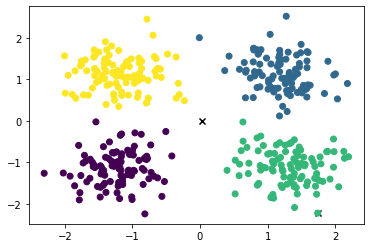

In [6]:
def gauss_sample(xmean, xsig, ymean, ysig, n, classnum):
    xsamp = np.random.normal(xmean, xsig, [n, 1])
    ysamp = np.random.normal(ymean, ysig, [n, 1])
    return np.hstack((xsamp, ysamp)), np.full([n], fill_value=classnum)

# Create dataset from sampling the gaussians
x1, y1 = gauss_sample(-1.2, 0.4, -1.2, 0.4, 100, 0)
x2, y2 = gauss_sample(1.2, 0.4, 1.2, 0.4, 100, 1)
x3, y3 = gauss_sample(1.2, 0.4, -1.2, 0.4, 100, 2)
x4, y4 = gauss_sample(-1.2, 0.4, 1.2, 0.4, 100, 3)

X = np.vstack((x1, x2, x3, x4))
y = np.concatenate((y1, y2, y3, y4))

p = np.random.permutation(X.shape[0])
X, y = X[p], y[p]

X = torch.from_numpy(X).type(torch.FloatTensor)
y = torch.from_numpy(y).type(torch.LongTensor)

train_mean = torch.mean(X, dim=0)
train_dist = torch.abs(torch.sqrt(torch.sum((train_mean - X)**2, dim=1)))
train_radius, train_idx = torch.max(train_dist) + 0.5, torch.argmax(train_dist)
print("Train radius: ", train_radius)

plt.scatter(train_mean[0], train_mean[1], marker='x', c='k')
plt.scatter(X[train_idx, 0], X[train_idx, 1], marker='x', c='k')
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
plt.show()

In [7]:
# Define network
net = LocalNet(train_mean=train_mean, train_radius=train_radius, layer_sizes=[2, 100, 4], mean=False, local=False, hyperprior_dim=32, code_dim=4) #, activation='logsoftmax')
# net = OldNet(layer_sizes=[2, 100, 4], mean=False, local=False, hyperprior_dim=32, code_dim=4) #, activation='logsoftmax')
optim = torch.optim.Adam(net.parameters(), lr=0.01)
# sched = torch.optim.lr_scheduler.StepLR(optim, step_size=5000, gamma=0.75)
ce = nn.CrossEntropyLoss()

nll = nn.NLLLoss()

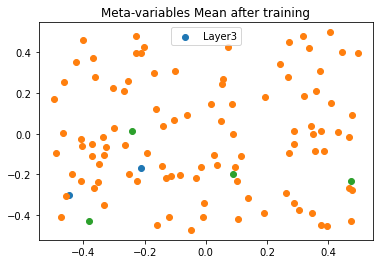

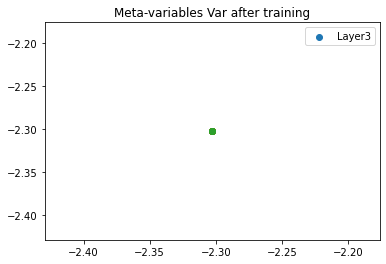

In [8]:
# Plot metaspace mean/var
plot_metaspace_mean(net, train=False)
plot_metaspace_var(net, train=False)
# plot_weight_correlations(net, X, 12, 0)

In [9]:
net(torch.Tensor([[3, 3], [1,1]]))

tensor([[-0.0369, -0.0222, -0.0313, -0.0408],
        [-0.0512, -0.0330, -0.0601, -0.0717]], grad_fn=<StackBackward>)

(13688, 2)


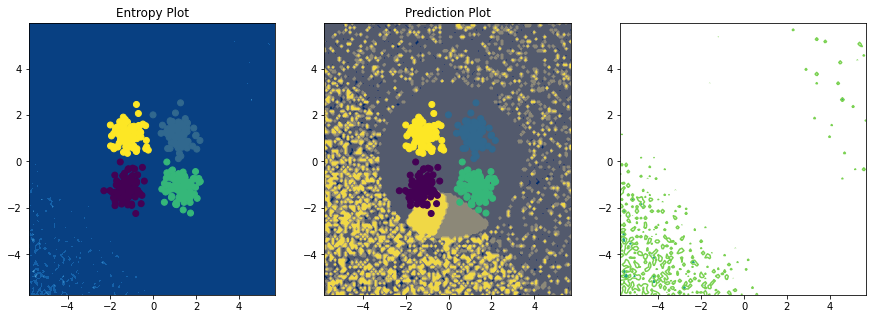

Ep 0: CE 1.38842 KLZ 1747.46191 Acc 0.2525
(13688, 2)


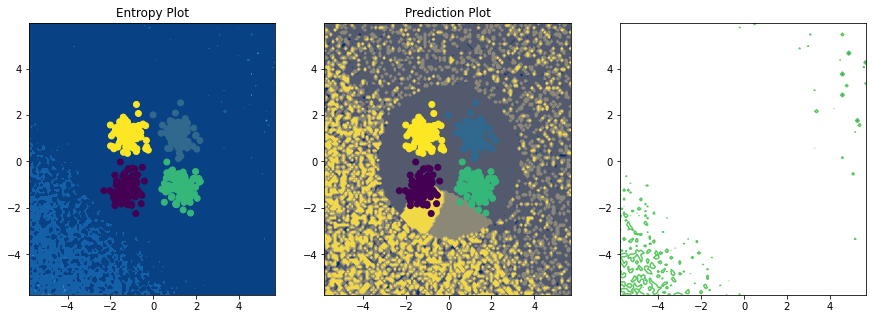

Ep 100: CE 0.00541 KLZ 827.73541 Acc 0.995
(13688, 2)


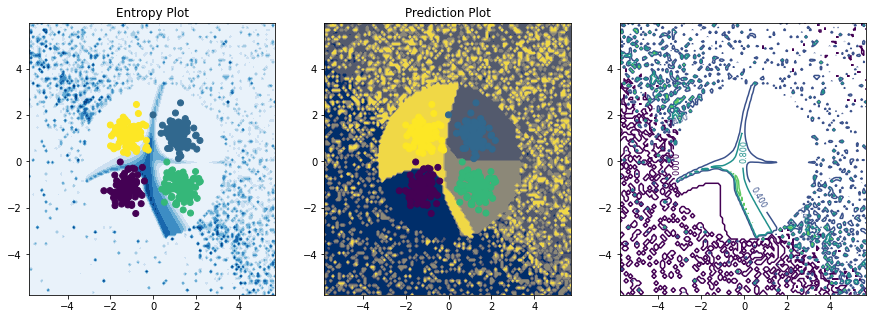

Ep 200: CE 0.00540 KLZ 624.94641 Acc 0.9975
(13688, 2)


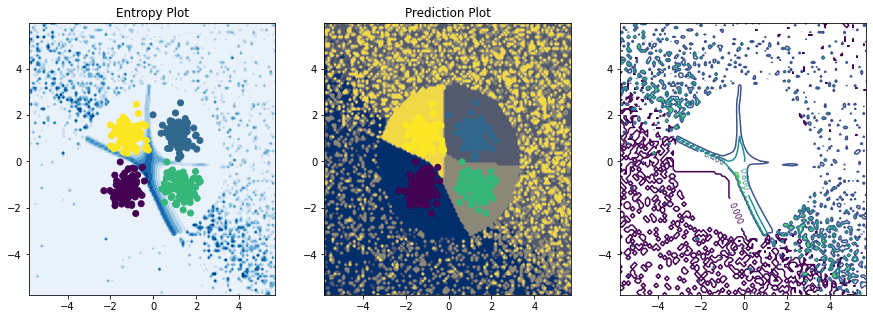

Ep 300: CE 0.00098 KLZ 498.25378 Acc 0.9975
(13688, 2)


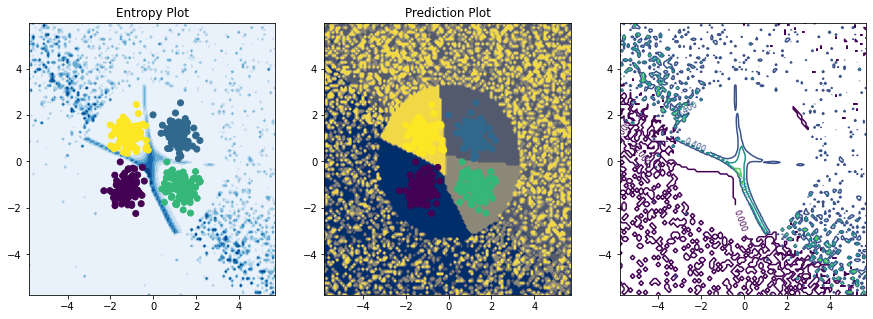

Ep 400: CE 0.00059 KLZ 421.83707 Acc 0.9975
(13688, 2)


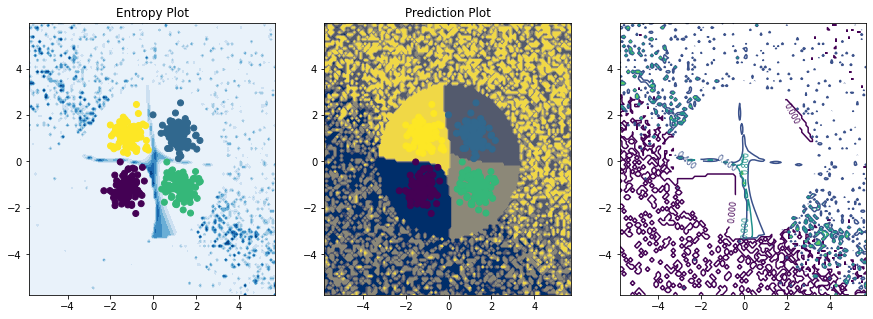

Ep 500: CE 0.01573 KLZ 773.67578 Acc 0.995
(13688, 2)


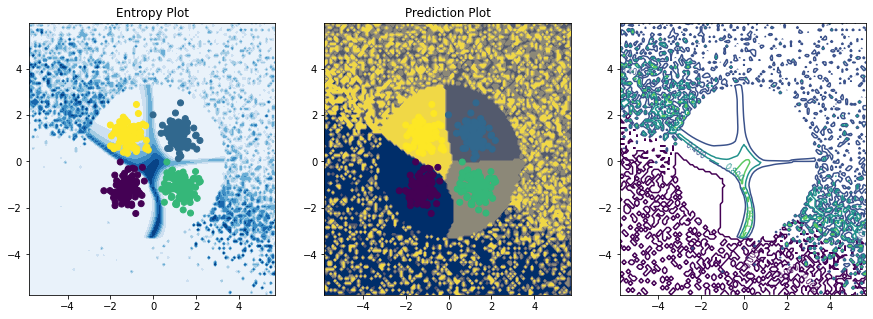

Ep 600: CE 0.00143 KLZ 713.78503 Acc 0.995
(13688, 2)


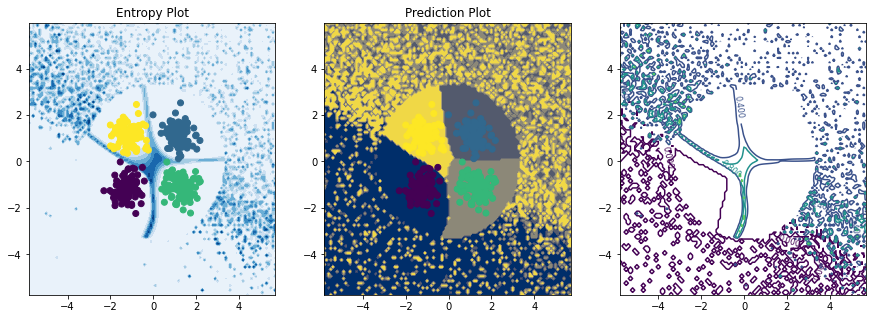

Ep 700: CE 0.00306 KLZ 621.49921 Acc 0.9975
(13688, 2)


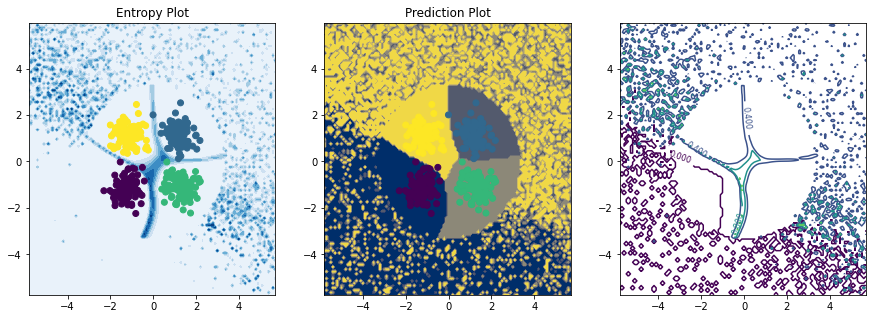

Ep 800: CE 0.00059 KLZ 551.90424 Acc 0.9975
(13688, 2)


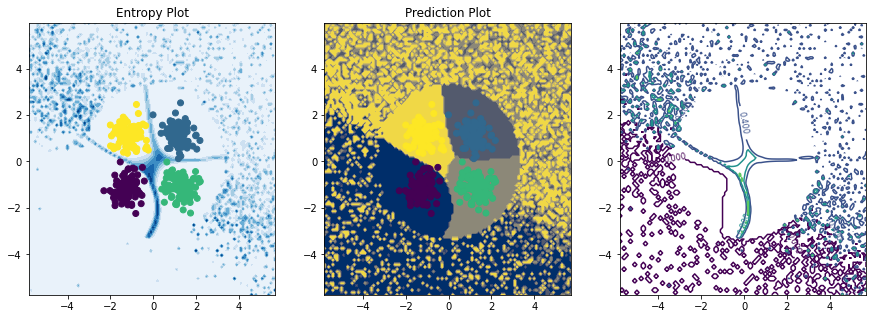

Ep 900: CE 0.00202 KLZ 508.17557 Acc 0.9975
(13688, 2)


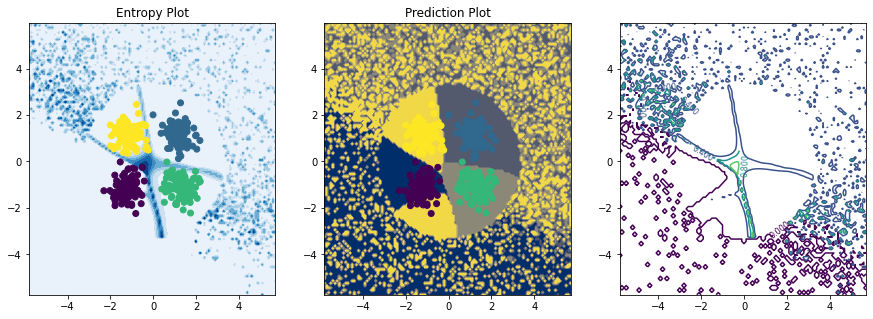

Ep 1000: CE 0.08432 KLZ 1331.37427 Acc 0.9925
(13688, 2)


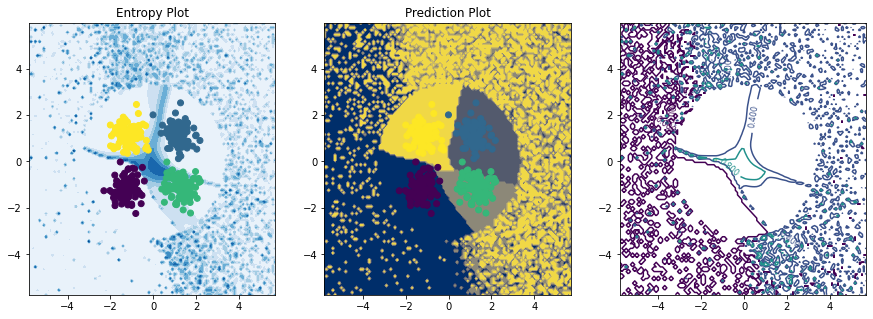

Ep 1100: CE 0.01243 KLZ 1254.10449 Acc 0.9975
(13688, 2)


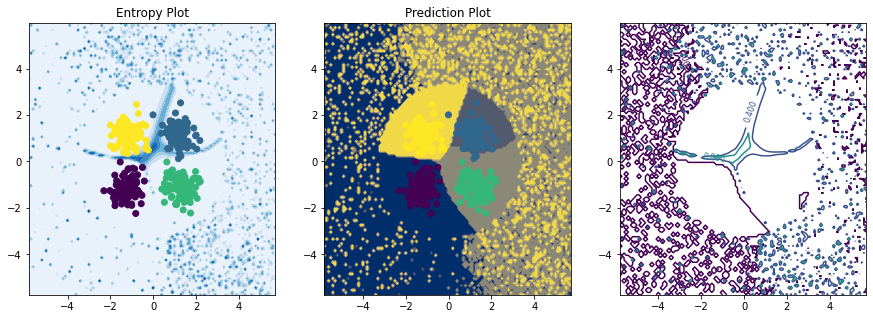

Ep 1200: CE 0.00157 KLZ 1182.66174 Acc 0.995
(13688, 2)


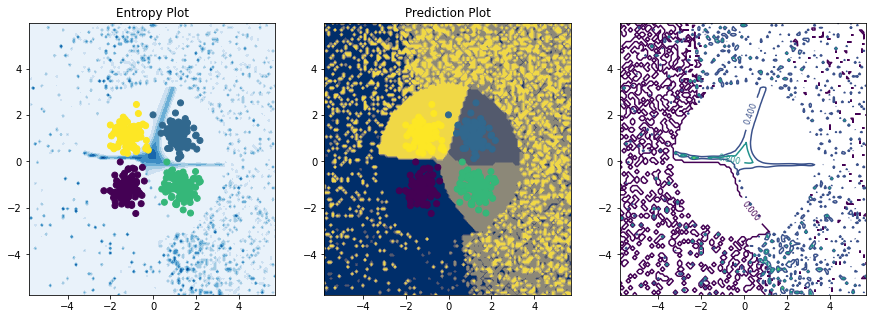

KeyboardInterrupt: 

In [10]:
plot_decision_boundary(lambda x: predict(x), X, y)
for ep in tqdm(range(100000)):
    optim.zero_grad()


#     clear_output()
    # Sub-sample
    indices = torch.randperm(len(X))[:50]
    x_batch, y_batch = X[indices], y[indices]

#     celoss = 0
#     for _ in range(5):
    preds = net(x_batch)

    cel = ce(preds, y_batch)
    celoss = cel

#     celoss /= 5

    acc = sum(np.argmax(net(X).detach().cpu().numpy(), axis=1) == y.numpy()) / y.shape[0]

    klz = net.kl_term()
    loss = celoss + 0.00001 * klz

    if ep % 100 == 0:
        print("Ep {}: CE {:0.5f} KLZ {:0.5f} Acc {}".format(ep, celoss, klz, acc))
        plot_decision_boundary(lambda x: predict(x), X, y)
    
    loss.backward()
    optim.step()
#     sched.step()
#     
#     # Plot metaspace mean/var
#     plot_metaspace_mean(net, train=True)
#     plot_metaspace_var(net, train=True)
# #     plot_weight_correlations(net, X, 50, 0)
#     time.sleep(1)
#     plot_decision_boundary(lambda x: predict(x), X, y)
#     time.sleep(1)

plot_decision_boundary(lambda x: predict(x), X, y)


In [ ]:
# Plot metaspace mean/var
plot_metaspace_mean(net, train=False)
plot_metaspace_var(net, train=False)
# plot_weight_correlations(net, X, 12, 0)